In [78]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/3-90+_DaysPastDue/data")

train = pd.read_csv("train.csv", na_values=["", "NA"])

test = pd.read_csv("test.csv", na_values=["", "NA"])

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# Process data

Remove upper and lower 1% of feature 3 for train but not test.

In [79]:
lower_bound = train['feature_3'].quantile(0.01)
upper_bound = train['feature_3'].quantile(0.99)

train = train[(train['feature_3'] >= lower_bound) & (train['feature_3'] <= upper_bound)]

Replace na with median value for both.

In [80]:
train['date'] = pd.to_datetime(train['date']).dt.year
test['date'] = pd.to_datetime(test['date']).dt.year

def impute_feature_2(df):
    df = df.sort_values(by=['id', 'date'])
    df['feature_2'] = df['feature_2'].fillna(method='ffill')
    df['feature_2'] = df['feature_2'].fillna(method='bfill')
    return df

train = train.groupby('id', group_keys=False).apply(impute_feature_2)
test = test.groupby('id', group_keys=False).apply(impute_feature_2)

Replace y with 1 if 90+DPD and 0 if active.

In [81]:
train['y'] = train['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)
test['y'] = test['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)

Standardize features.

In [82]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = scaler.fit_transform(train[['feature_1', 'feature_2', 'feature_3', 'feature_4']])
test[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = scaler.transform(test[['feature_1', 'feature_2', 'feature_3', 'feature_4']])

# Logistic Regression Model 

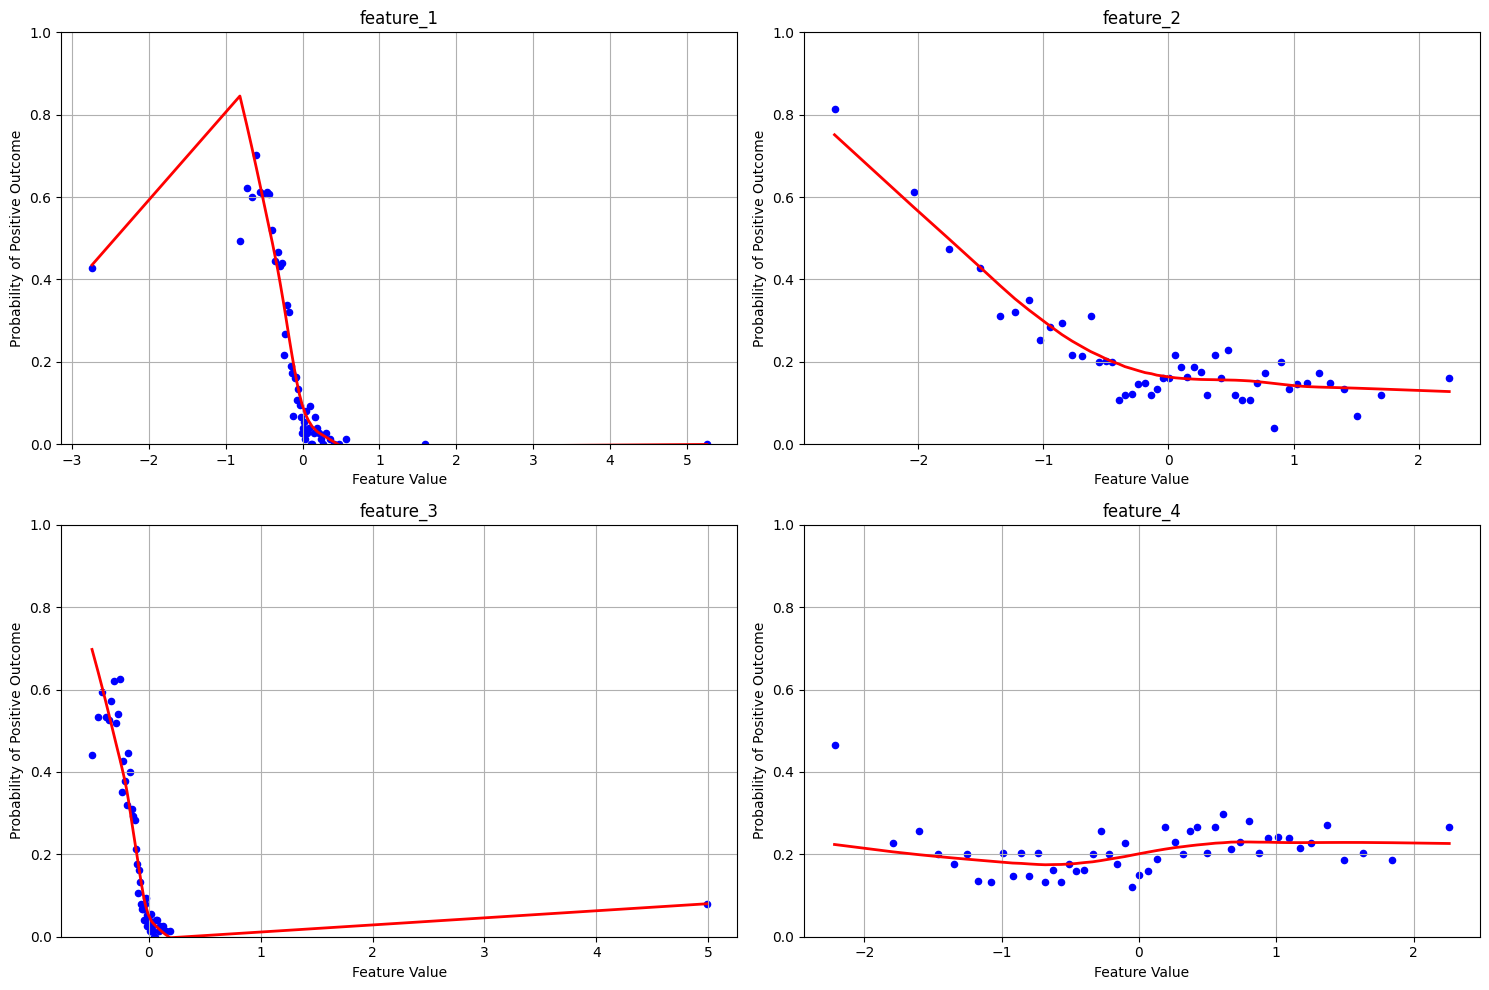

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(features):
    bins = pd.qcut(train[feature], q=50, duplicates='drop')
    bin_means = train.groupby(bins)[feature].mean()
    bin_probs = train.groupby(bins)['y'].mean()
    
    axes[idx].scatter(bin_means, bin_probs, color='blue', s=20)
    sns.regplot(x=bin_means, y=bin_probs, scatter=False, lowess=True,
                color='red', line_kws={'lw': 2}, ax=axes[idx])
    
    axes[idx].set_title(feature)
    axes[idx].set_xlabel('Feature Value')
    axes[idx].set_ylabel('Probability of Positive Outcome')
    axes[idx].set_ylim(0, 1)
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

Produce all possible interaction terms.

In [84]:
train['feature_1_x_feature_2'] = train['feature_1'] * train['feature_2']
test['feature_1_x_feature_2'] = test['feature_1'] * test['feature_2']

train['feature_1_x_feature_3'] = train['feature_1'] * train['feature_3']
test['feature_1_x_feature_3'] = test['feature_1'] * test['feature_3']

train['feature_1_x_feature_4'] = train['feature_1'] * train['feature_4']
test['feature_1_x_feature_4'] = test['feature_1'] * test['feature_4']

train['feature_2_x_feature_3'] = train['feature_2'] * train['feature_3']
test['feature_2_x_feature_3'] = test['feature_2'] * test['feature_3']

train['feature_2_x_feature_4'] = train['feature_2'] * train['feature_4']
test['feature_2_x_feature_4'] = test['feature_2'] * test['feature_4']

train['feature_3_x_feature_4'] = train['feature_3'] * train['feature_4']
test['feature_3_x_feature_4'] = test['feature_3'] * test['feature_4']

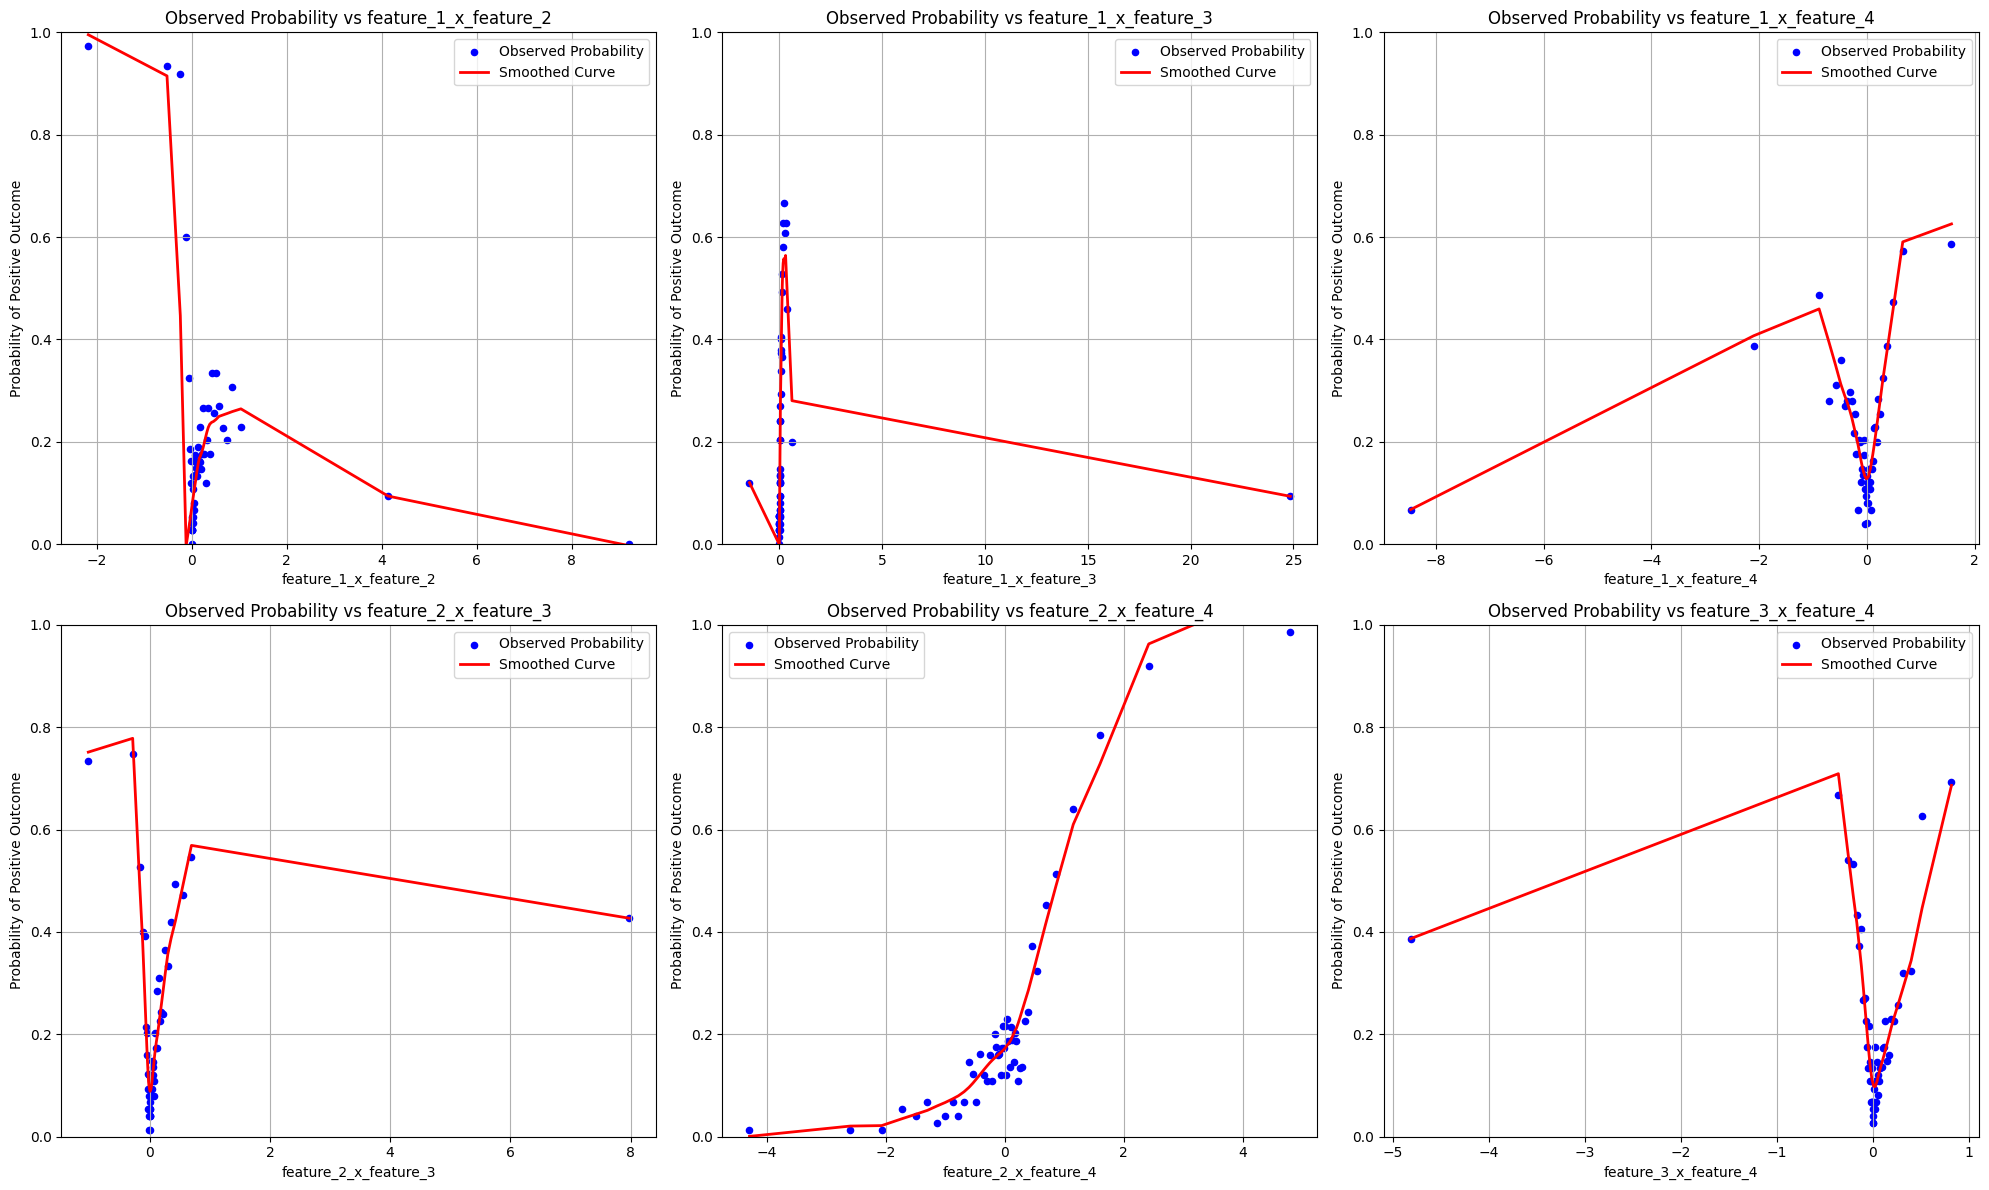

In [85]:
interaction_terms = [
    ('feature_1', 'feature_2'),
    ('feature_1', 'feature_3'), 
    ('feature_1', 'feature_4'),
    ('feature_2', 'feature_3'),
    ('feature_2', 'feature_4'),
    ('feature_3', 'feature_4')
]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 12))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i, (feat1, feat2) in enumerate(interaction_terms):
    interaction_name = f'{feat1}_x_{feat2}'
    train[interaction_name] = train[feat1] * train[feat2]
    test[interaction_name] = test[feat1] * test[feat2]
    
    bins = pd.qcut(train[interaction_name], q=50, duplicates='drop')
    bin_means = train.groupby(bins)[interaction_name].mean()
    bin_probs = train.groupby(bins)['y'].mean()
    
    axes[i].scatter(bin_means, bin_probs, color='blue', s=20, label='Observed Probability')
    sns.regplot(x=bin_means, y=bin_probs, scatter=False, lowess=True,
                color='red', line_kws={'lw': 2}, ax=axes[i], label='Smoothed Curve')
    
    axes[i].set_title(f'Observed Probability vs {interaction_name}')
    axes[i].set_xlabel(interaction_name)
    axes[i].set_ylabel('Probability of Positive Outcome')
    axes[i].set_ylim(0, 1)
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

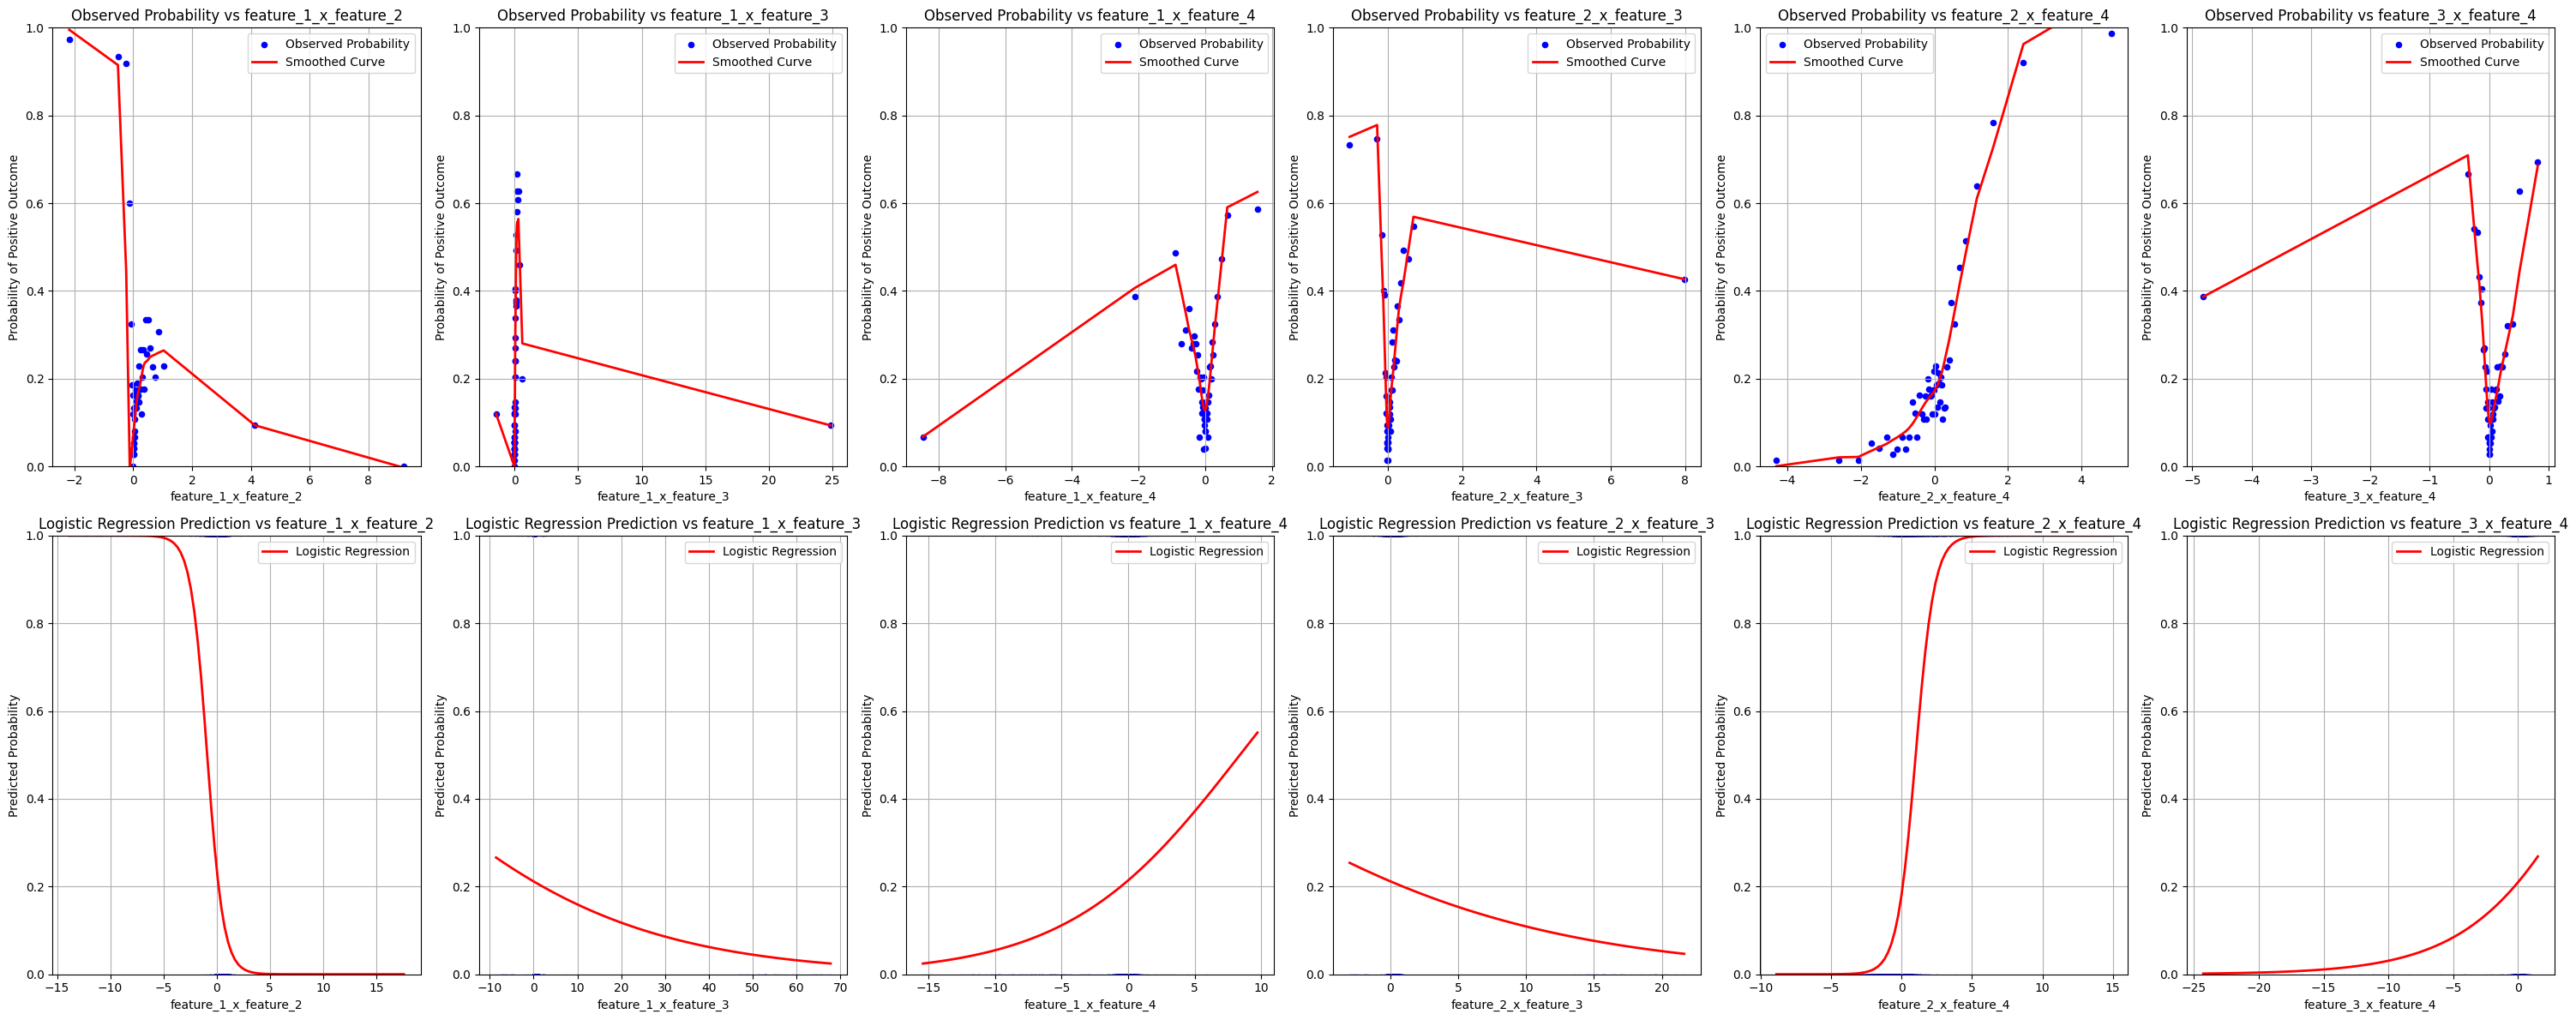

In [86]:
interaction_terms = [
    ('feature_1', 'feature_2'),
    ('feature_1', 'feature_3'), 
    ('feature_1', 'feature_4'),
    ('feature_2', 'feature_3'),
    ('feature_2', 'feature_4'),
    ('feature_3', 'feature_4')
]

fig, ((ax1, ax2, ax3, ax4, ax5, ax6), 
      (ax7, ax8, ax9, ax10, ax11, ax12)) = plt.subplots(2, 6, figsize=(30, 12))
axes_top = [ax1, ax2, ax3, ax4, ax5, ax6]
axes_bottom = [ax7, ax8, ax9, ax10, ax11, ax12]

for i, (feat1, feat2) in enumerate(interaction_terms):
    interaction_name = f'{feat1}_x_{feat2}'
    train[interaction_name] = train[feat1] * train[feat2]
    test[interaction_name] = test[feat1] * test[feat2]
    
    # Top row - observed probabilities
    bins = pd.qcut(train[interaction_name], q=50, duplicates='drop')
    bin_means = train.groupby(bins)[interaction_name].mean()
    bin_probs = train.groupby(bins)['y'].mean()
    
    axes_top[i].scatter(bin_means, bin_probs, color='blue', s=20, label='Observed Probability')
    sns.regplot(x=bin_means, y=bin_probs, scatter=False, lowess=True,
                color='red', line_kws={'lw': 2}, ax=axes_top[i], label='Smoothed Curve')
    
    axes_top[i].set_title(f'Observed Probability vs {interaction_name}')
    axes_top[i].set_xlabel(interaction_name)
    axes_top[i].set_ylabel('Probability of Positive Outcome')
    axes_top[i].set_ylim(0, 1)
    axes_top[i].legend()
    axes_top[i].grid(True)
    
    # Bottom row - logistic regression predictions
    X = train[interaction_name].values.reshape(-1, 1)
    y = train['y']
    model = LogisticRegression()
    model.fit(X, y)
    
    X_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred = model.predict_proba(X_plot)[:, 1]
    
    axes_bottom[i].scatter(train[interaction_name], y, color='blue', s=1, alpha=0.1)
    axes_bottom[i].plot(X_plot, y_pred, color='red', lw=2, label='Logistic Regression')
    
    axes_bottom[i].set_title(f'Logistic Regression Prediction vs {interaction_name}')
    axes_bottom[i].set_xlabel(interaction_name)
    axes_bottom[i].set_ylabel('Predicted Probability')
    axes_bottom[i].set_ylim(0, 1)
    axes_bottom[i].legend()
    axes_bottom[i].grid(True)

plt.tight_layout()
plt.show()

In [87]:
base_features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
interaction_names = ['feature_1_x_feature_2', 'feature_1_x_feature_3', 'feature_1_x_feature_4',
                    'feature_2_x_feature_3', 'feature_2_x_feature_4', 'feature_3_x_feature_4']

X_train = train[base_features + interaction_names]
X_test = test[base_features + interaction_names]
y_train = train['y']
y_test = test['y']

model = LogisticRegression()
model.fit(X_train, y_train)

train_pred = model.predict_proba(X_train)[:, 1]
test_pred = model.predict_proba(X_test)[:, 1]


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values